##Import various python functions and modules that we need.

In [1]:
from pandas import DataFrame
from IPython.display import FileLink

##Pylab namespace and inline plots. Import Rmagic.

In [2]:
%matplotlib inline
%load_ext rpy2.ipython

##Import R libraries we'll use.

In [3]:
%%R
library(phyloseq)
library(ggplot2)
library(foreach)
library(doParallel)
library(gridExtra)

foreach: simple, scalable parallel programming from Revolution Analytics
Use Revolution R for scalability, fault tolerance and more.
http://www.revolutionanalytics.com
Loading required package: iterators
Loading required package: parallel
Loading required package: grid


##Import data into R. Prune to relevant samples (PS, non-bulk). Get rid of OTUs not observed in at least 25% of samples)

###These files are from the [binning notebook](./OTU_binning.ipynb), [tree notebook](./Tree.ipynb), [merge mappers notebook](./Merge_mappers.ipynb) 

In [4]:
%%R
physeq = import_biom("/var/seq_data/priming_exp/data/otu_table.biom", "/var/seq_data/priming_exp/data/otusn.tree")
#print(physeq)
#sample.data = read.csv(file = "/var/seq_data/priming_exp/data/allsample_metadata_nomock.csv")
sample.data = import_qiime_sample_data("/var/seq_data/priming_exp/data/allsample_metadata_nomock.txt")
#print(sample.data)
physeq = merge_phyloseq(physeq,sample.data)
#print(physeq)
physeq.md = sample_data(physeq)
physeq.PE = prune_samples((physeq.md$Bulk == 0)& 
                          (!(physeq.md$Sample %in% c("13C.700.45.03.21", "12C.000.28.03.27")))&
                          (physeq.md$Treatment %in% c("12C700","13C700")), physeq)
physeq.PE.snorm = transform_sample_counts(physeq.PE, function(x) x/sum(x))
physeq.PE.thresh = filter_taxa(physeq.PE.snorm, function(x) sum(x > 0) > (0.25 * length(x)), TRUE)
print(physeq.PE.thresh)


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3323 taxa and 121 samples ]
sample_data() Sample Data:       [ 121 samples by 13 sample variables ]
phy_tree()    Phylogenetic Tree: [ 3323 tips and 3322 internal nodes ]


In [5]:
%%R
print(colnames(physeq.md))

 [1] "Sample"       "FractionNum"  "Bulk"         "Control"      "CC"          
 [6] "X100"         "X700"         "H2O"          "Day"          "Density"     
[11] "rep"          "contolVlabel" "Treatment"   


###Calculate pairwise weighted unifrac distances between samples.

In [6]:
%%R
registerDoParallel(cores=20)
wunif.dist = distance(physeq.PE.thresh, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

###Ordinate using weighted unifrac distnaces with NMDS.

In [7]:
%%R
nmds = ordinate(physeq.PE.thresh, 
                method = "NMDS", 
                distance = wunif.dist)

Run 0 stress 0.08740728 
Run 1 stress 0.08735223 
... New best solution
... procrustes: rmse 0.001974482  max resid 0.02102319 
Run 2 stress 0.1368393 
Run 3 stress 0.120348 
Run 4 stress 0.08768497 
... procrustes: rmse 0.003259923  max resid 0.03482416 
Run 5 stress 0.08740713 
... procrustes: rmse 0.001988104  max resid 0.02108943 
Run 6 stress 0.1285439 
Run 7 stress 0.1133256 
Run 8 stress 0.1028978 
Run 9 stress 0.1541151 
Run 10 stress 0.09360137 
Run 11 stress 0.1090088 
Run 12 stress 0.1100226 
Run 13 stress 0.09429541 
Run 14 stress 0.08893972 
Run 15 stress 0.08821984 
Run 16 stress 0.1543886 
Run 17 stress 0.08827456 
Run 18 stress 0.08887464 
Run 19 stress 0.08735224 
... procrustes: rmse 1.856557e-05  max resid 0.0001155577 
*** Solution reached


NULL


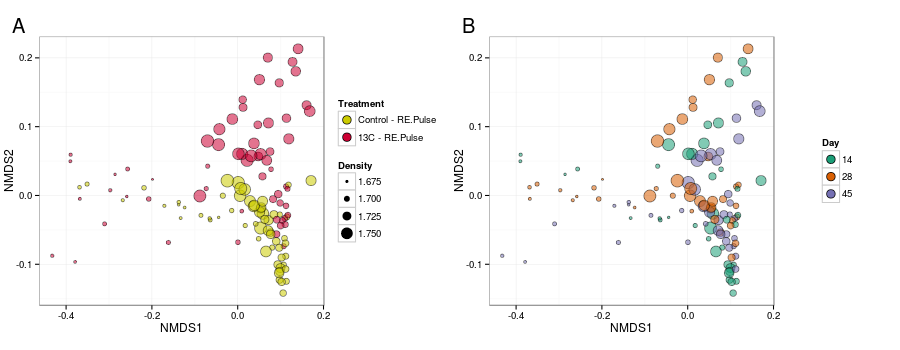

In [13]:
%%R -w 900 -h 350

colours = c("#CCCC00", "#CC0033", "#ff7f00", "#377eb8", "#4daf4a", "#00f5ff", "#ff4040", "#68228b")

df = plot_ordination(physeq.PE.thresh, nmds, justDF = TRUE)
df$Density = as.numeric(as.character(df$Density))

p1 = ggplot(df, aes(x = NMDS1, y = NMDS2)) 
p1 = p1 + geom_point(aes(fill = Treatment, size = Density, alpha = 0.85), shape=21) 
p1 = p1 + scale_fill_manual(values = colours,
                            breaks=c("12C700", "13C700"),
                            labels=c("Control - RE.Pulse","13C - RE.Pulse"))
p1 = p1 + guides(alpha = FALSE)
p1 = p1 + scale_size_area(aesthetics = "Density")
p1 = p1 + ggtitle("A")
p1 = p1 + guides(fill = guide_legend(override.aes = list(size = 4)))
p1 = p1 + guides(size = guide_legend(override.aes = list(fill = "black")))
p1 = p1 + theme_bw()
p1 = p1 + theme(plot.margin = unit(c(1,0,1,0), "lines"))
p1 = p1 + theme(plot.title = element_text(hjust = -0.1, size = 20))

p2 = ggplot(df, aes(x = NMDS1, y = NMDS2))
p2 = p2 + geom_point(aes(fill = factor(Day), size = Density, alpha = 0.85), shape=21)
p2 = p2 + scale_fill_brewer(palette="Dark2")
p2 = p2 + guides(alpha = FALSE, size = FALSE)
p2 = p2 + scale_size_area(aesthetics = "Density")
p2 = p2 + ggtitle("B")
p2 = p2 + guides(fill = guide_legend(title = "Day", override.aes = list(size = 4)))
p2 = p2 + theme_bw()
p2 = p2 + theme(plot.margin = unit(c(1,0,1,0), "lines"))
p2 = p2 + theme(plot.title = element_text(hjust = -0.1, size = 20))


gp1 = ggplot_gtable(ggplot_build(p1))
gp2 = ggplot_gtable(ggplot_build(p2))
maxWidth = unit.pmax(gp1$widths[2:5], gp2$widths[2:5])

gp1$widths[2:5] <- maxWidth
gp2$widths[2:5] <- maxWidth

p.combined = grid.arrange(gp1, gp2, ncol = 2)
p.combined

In [14]:
%%R -w 1000 -h 350
pdf("figs/ordination_700.pdf", width = 12, height = 5)
grid.arrange(p1, p2, widths = c(1.2, 1), ncol=2)
dev.off()

png 
  2 


In [15]:
FileLink("figs/ordination_700.pdf")

/home/ashley/priming_exp/figs/ordination_700.pdf

In [16]:
%%R
png("figs/ordination_700.png", width = 12, height = 5, units = "in", res = 600)
grid.arrange(p1, p2, widths = c(1.2, 1), ncol=2)
dev.off()

png 
  2 


In [17]:
FileLink("figs/ordination_700.png")

/home/ashley/priming_exp/figs/ordination_700.png